## The Problem

The Kaggle House Prices competition challenges us to predict the sale price of homes sold in Ames, Iowa between 2006 and 2010. The dataset contains 79 explanatory variables that include a vast array of house attributes. You can read more about the problem on the competition website, [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

## Our Approach

Because our target variable is continuous (sale price), this is a classic example of a regression problem, reminiscent of the Boston Housing dataset. We will be judged by how close our predictions are to the actual sale prices, as measured by the root mean squared error between the logarithm of the predicted value and the logarithm of the observed sales price. 

Our dataset has a large number of explanatory variables, many of which are categorical, and thus feature selection will be a crucial component of this problem. Two common approaches for this problem are using the straightforward SelectKBest method from the scikit-learn library and LASSO regression. Although I tried both approached in my analysis, LASSO yielded better results. 

Additionally, we will use XGBoost and blend the results with our LASSO output in order to improve the accuracy of our model. Our final results are good enough for a top 10% score on the leaderboard as of the time of this writing. 

## Exploratory Data Analysis

For the purporses of this write-up, I will not go into a detailed demonstration of all exploratory data analysis, primarily because the quantity of variables would make this document unwieldy for the reader. Instead, I'll simply recount my primary observations that will inform our feature engineering. Those observations are:  

 - we have a large number of categorical attributes which we will have to convert into dummy variables
 - a few of the numerical columns have nulls that we will have to fill in
 - many of the numerical columns have skewed distributions, which we will want to address

Below, we load our essential libraries and the data for our analysis.

In [3]:
import os
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

## Feature Engineering

First, we convert the MSSubClass variable (which represents the building class code) from numerical to string, since the codes are merely categories and have no ordinal significance. 

In [19]:
def mssubclass(train, test, cols=['MSSubClass']):
    for i in (train, test):
        for z in cols:
            i[z] = i[z].apply(lambda x: str(x))
    return train, test

Next, we will take the log of all the numerical features, including our dependent variable. We use 'log1p' because our numerical features have a lot of zeros, and this will add one to each value before taking the log.

In [20]:
def log(train, test, y):
    numeric_feats = train.dtypes[train.dtypes != "object"].index
    for i in (train, test):
        i[numeric_feats] = np.log1p(i[numeric_feats])
    y = np.log1p(y)
    return train, test, y

We will impute the null the values by taking each column's mean. 

In [23]:
def impute_mean(train, test):
    for i in (train, test):
        for s in [k for k in i.dtypes[i.dtypes != "object"].index if sum(pd.isnull(i[k])>0)]:
            i[s] = i[s].fillna(i[s].mean())
    return train, test

When creating our dummy variables, we will also make sure that the null values are recognized as such, since there might be some significance to them. 

In [24]:
def dummies(train, test):
    columns = [i for i in train.columns if type(train[i].iloc[1]) == str or type(train[i].iloc[1]) == float]
    for column in columns:
        train[column].fillna('NULL', inplace = True)
        good_cols = [column+'_'+i for i in train[column].unique()[1:] if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test

In [25]:
train, test = mssubclass(train, test)
train, test, y = log(train, test, y)
train, test = lotfrontage(train, test)
train, test = garageyrblt(train, test)
train, test = impute_mean(train, test)
train, test = dummies(train, test)

## LASSO Regression 

Lasso regression performs both regularization and feature selection in order to improve the prediction of our model. In our case, this is the perfect algorithm because it will help us reduce the number of feature and mitigate overfitting. 

The main hyperparameter we need to tune in a LASSO regression is the regularization factor alpha. In order to find the optimal alpha, we will use GridSearchCV. 

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_ridge = [1e-5, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]

coeffs = {}
for alpha in alpha_ridge:
    r = Lasso(alpha=alpha, normalize=True, max_iter=1000000)
    r = r.fit(train, y)
    
grid_search = GridSearchCV(Lasso(alpha=alpha, normalize=True), scoring='neg_mean_squared_error',
                           param_grid={'alpha': alpha_ridge}, cv=10, n_jobs=-1)
grid_search.fit(train, y)

print grid_search.best_estimator_
print grid_search.score(train, y)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
-0.01176265768


Having identified our optimal alpha of 0.0001, we can also visualize the root mean squared error of all the other alphas. 

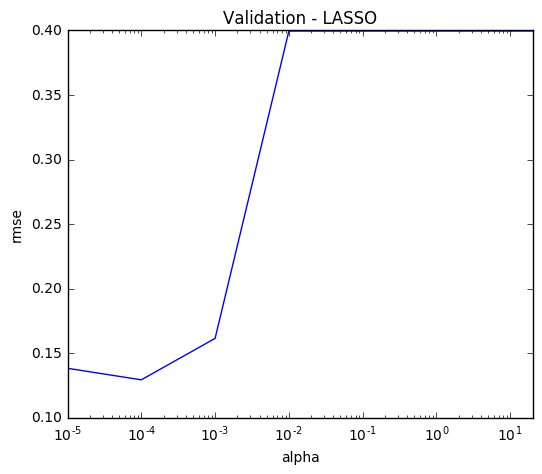

In [28]:
alpha = alpha_ridge
rmse = list(np.sqrt(-grid_search.cv_results_['mean_test_score']))

plt.figure(figsize=(6,5))
lasso_cv = pd.Series(rmse, index = alpha)
lasso_cv.plot(title = "Validation - LASSO", logx=True)
plt.xlabel("alpha")
plt.ylabel("rmse")

We now fit the model to our training data. 

In [29]:
lasso = Lasso(alpha=.0001, normalize=True, max_iter=1e6)
lasso = lasso.fit(train, y)

How many columns has our model chosen?

In [31]:
coef = pd.Series(lasso.coef_, index = train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 103 variables and eliminated the other 142 variables


Additionally, below we can see that the age, size, and overall condition of the house are the most important variables according to our model. This matches our intuition, which is always a good sanity check when building models. 

In [32]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

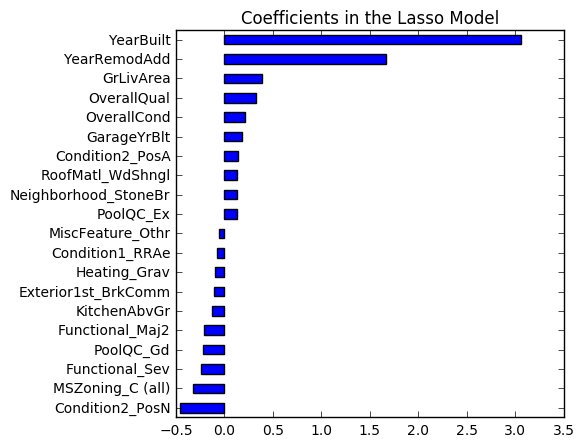

In [33]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

When we predict the test data using the Lasso model, we get a root mean squared error of 0.1209, which is good enough for the top 25 on the leaderboard. 

In [34]:
lasso_pred = lasso.predict(test)

score: .12090

## XGBoost Model

XGBoost models have become a household name in past year due to their strong performance in data science competitions. One of the challenges with this algorithm is the potential length of time it takes to tune the hyperparameters when dealing with large datasets. However, because our dataset has less than 1,500 observations, this was a great opportunity for me to test out the algorithm. In the spirit of parsimony, I will not display the details of my hyperparameter tuning. However, the main technique I used was by cross-validating one or two parameters at a time in order to not overburden my machine, while recalculating the optimal number of estimators between each tuning session.

Below is the final model that I implemented. It scored a 0.12278, which in fact is worse than the LASSO model. 

In [35]:
regr = xgb.XGBRegressor(
                 colsample_bytree=0.3,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=1668,                                                                  
                 reg_alpha=1,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

regr.fit(train, y)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(train)
y_test = y
print("XGBoost score on training set: ", mean_squared_error(y_test, y_pred))

# Run prediction on the Kaggle test set.
y_pred_xgb = regr.predict(test)

('XGBoost score on training set: ', 0.0058807337725166504)


score 0.12278

## Blending Model Results

Our last step is to combine the results from our two models and submit these results. I took a simple average of the predictions from our two models. The final score has a root mean squared error of 0.11765, which is markedly better than either of the two models individually. This confirms the primary principle used in ensemble methods, whereby the error rates of ensembles is lower than those of the individual models, assuming the error rates are not correlated. 

In [37]:
predictions = np.expm1(.6*lasso_pred + .4*y_pred_xgb)

score: 0.11765

## Conclusion

This competition was a great exercise in some standard regression techniques. I was able to achieve a top 10% score even though I performed minimal feature engineering, which I will leave as a later exercise for myself.  

In addition to the models above, I also tried SelectKBest (with Pipeline and Grid Search), which narrowed down the number of columns to 138 and yielded a score of 0.13215. However, this model didn't play nicely with the others when it came to blending. Lastly, I tried using a random forest regressor, but that returned a score of 0.14377, which isn't bad, but certainly not good enough to include in our ensemble. 

The complete code for this analysis can be found on my GitHub page: https://github.com/zlatankr/Projects/tree/master/Homes

I welcome any questions and comments.